# Thermodynamic profile

In [145]:
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
from datetime import datetime, timedelta
import glob
from copy import deepcopy
import math
from matplotlib import pyplot as plt
from matplotlib import dates
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

In [146]:
data_path_sounding = '/home/rjackson/data/soundings/'

In [147]:
# get_sounding_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
# Only 23 UTC is loaded following Pope et al. (2008)
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, start_minute, end_year,
                       end_month, end_day, end_hour, 
                       end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )
    deltatime = end_time - start_time

    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'twpsondewnpnC3.b1.' +
                      year_str +
                      month_str +
                      day_str +
                      '*.23*'
                     '*custom.cdf')
    
          
        data_list = glob.glob(format_str)
        if(i % 100 == 0):
            print(i)
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-11]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_sounding(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_sounding +
                     'twpsondewnpnC3.b1.' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.custom.cdf')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

Load netCDF sounding data

surface (assumed
here to be 1013 hPa), 950, 925, 900, 850, 800, 750, 700,
650, 600, 550, 500, 400, 300, 200, and 100 hPa (a total of
16 levels)

In [148]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

Here is where we input the times and pressure levels to get sounding from.

In [149]:
start_year = 2003
end_year = 2011

sounding_times = get_sounding_times(start_year,1,1,0,1,
                                    end_year,1,1,23,1)

pres_levels = np.arange(1000, 100, -5) 
print(len(sounding_times))

We are about to load sounding files for 2923 days
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
2781


Loop over all of the soundings.

In [150]:
## Save soundings at 16 levels for later

u_soundings = np.zeros((len(sounding_times),len(pres_levels)))
v_soundings = np.zeros((len(sounding_times),len(pres_levels)))
t_soundings = np.zeros((len(sounding_times),len(pres_levels)))
z_soundings = np.zeros((len(sounding_times),len(pres_levels)))
dp_soundings = np.zeros((len(sounding_times),len(pres_levels)))
time_soundings = []
pres_soundings = np.zeros((len(sounding_times),len(pres_levels)))
rh_soundings = np.zeros((len(sounding_times),len(pres_levels)))
dtdz_soundings = np.zeros((len(sounding_times),len(pres_levels)))
count = 0
no_masked = 0

for time in sounding_times:
    if(time.month <= 4 or time.month >= 9):
        if(time.hour == 23):
            pres_index = []
            # Load sounding file
            Sounding_netcdf = get_sounding(time)

            # Convert timestamps to datetime format        
            p = Sounding_netcdf.variables['pres'][:]
            u = Sounding_netcdf.variables['u_wind'][:]
            v = Sounding_netcdf.variables['v_wind'][:]
            t = Sounding_netcdf.variables['tdry'][:]
            z = Sounding_netcdf.variables['alt'][:]
            dp = Sounding_netcdf.variables['dp'][:]
            rh = Sounding_netcdf.variables['rh'][:]
            theta = t*np.power(1000/p, 0.286)
            # Take levels from the sounding and place them into the array
            
            for pres in pres_levels:
                pres_index.append(find_nearest(p,pres))
           
            
            # Check for availability of 16 pressure levels
            good_sounding = 1
            for i in range(0,len(pres_levels)-1):
                if(p[pres_index[i]] < pres_levels[i]-20 or
                    p[pres_index[i]] > pres_levels[i]+20):
                    good_sounding = 0
                if(abs(u[pres_index[i]]) > 75 or
                   abs(v[pres_index[i]]) > 75):
                    good_sounding = 0
            
            u = u[pres_index]
            v = v[pres_index]
            t = t[pres_index]
            z = z[pres_index]
            dp = dp[pres_index]
            rh = rh[pres_index]
            theta = theta[pres_index]
            dtdz = np.zeros(rh.shape)
            dtdz[1:] = (theta[1:]-theta[:-1])/(z[1:]-z[:-1])*1e3
            dtdz[0] = float('nan')
            for i in range(0,len(u)):
                if(u[i] < -75 or v[i] < -75 or
                   u[i] is np.ma.masked or
                   v[i] is np.ma.masked or
                   dp[i] is np.ma.masked or
                   t[i] is np.ma.masked or
                   dp[i] < -99):
                    good_sounding = 0
            
            if(t[0] < 0):
                t[:] = float('nan')
                good_sounding = 0
                
            # If pressure levels are not available, mask the entire sounding
            if(good_sounding == 0):
                no_masked = no_masked + 1
            else:    
                u_soundings[count][:] = u
                v_soundings[count][:] = v
                t_soundings[count][:] = t
                dp_soundings[count][:] = dp
                z_soundings[count][:] = z
                time_soundings.append(time)
                pres_soundings[count][:] = pres_levels
                rh_soundings[count][:] = rh
                dtdz_soundings[count][:] = dtdz
                count = count + 1   
                
    if(count % 100 == 0):
        print(time)

u_soundings = u_soundings[0:count-1][:]
v_soundings = v_soundings[0:count-1][:]
t_soundings = t_soundings[0:count-1][:]
dp_soundings = dp_soundings[0:count-1][:]
z_soundings = z_soundings[0:count-1][:]
pres_soundings = pres_soundings[0:count-1][:]
rh_soundings = rh_soundings[0:count-1][:]
dtdz_soundings = dtdz_soundings[0:count-1][:]
print(str((no_masked/(count+no_masked)*100)) + '% of soundings masked')

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in true_divide


2003-09-07 23:32:00
2004-01-08 23:20:00
2004-09-02 23:15:00
2004-12-23 23:15:00
2005-04-21 23:18:00
2005-04-22 23:16:00
2005-04-23 23:25:00
2005-12-18 23:18:00
2006-04-28 23:16:00
2007-01-04 23:21:00
2007-01-05 23:19:00
2007-01-06 23:19:00
2007-01-07 23:16:00
2007-09-02 23:15:00
2007-12-25 23:16:00
2008-04-16 23:15:00
2008-12-07 23:15:00
2009-04-28 23:39:00
2010-01-07 23:15:00
2010-04-27 23:21:00
2010-12-27 23:17:00
12.643051771117166% of soundings masked


[-25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8
  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10
  11  12  13  14  15  16  17  18  19  20  21  22  23  24]
(1602, 180)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


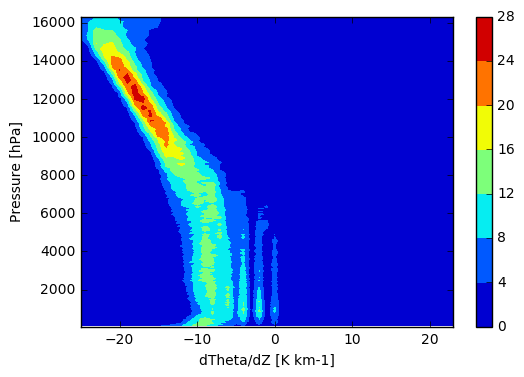

In [155]:
dtdz_bins = np.arange(-25,25,1)
dtdz_hist = np.zeros((len(pres_levels), len(dtdz_bins)-1))
print(dtdz_bins)
print(dtdz_soundings.shape)
for i in range(len(pres_levels)):
    array = dtdz_soundings[:,i]
    array = array[np.isfinite(array)]
    hist, bins = np.histogram(array, bins=dtdz_bins)
    dtdz_hist[i,:] = hist/np.sum(hist)*100

X,Y = np.meshgrid(dtdz_bins[:-1], z_soundings[1])
plt.contourf(X, Y, dtdz_hist)
plt.xlabel('dTheta/dZ [K km-1]')
plt.ylabel('Pressure [hPa]')
plt.colorbar()


## Time-height sections

Plot dT/dz

[[         nan          nan          nan ...,          nan          nan
           nan]
 [         nan -10.46648884  -6.99826288 ..., -23.80912971 -23.01782227
  -25.63617897]
 [         nan  -6.72502518  -9.47255516 ..., -23.48998833 -19.84780884
  -23.91675949]
 ..., 
 [         nan -14.29711151  -8.3967247  ..., -14.57930565 -21.36631393
  -18.85065079]
 [         nan   0.80856013   0.80521899 ..., -20.14596939 -17.89255333
  -14.88517952]
 [         nan -16.75544167 -13.43847847 ..., -21.47901726 -14.27643681
  -15.78693295]]


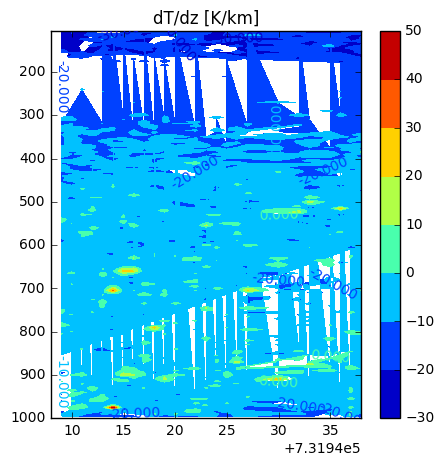

In [152]:
# Input start and end times
start_year = 2005
start_month = 1
start_day = 1

start_time = datetime(year=start_year, 
                      month=start_month, 
                      day=start_day)
end_year = 2005
end_month = 2
end_day = 1

end_time = datetime(year=end_year, 
                    month=end_month, 
                    day=end_day)

indicies = []
datenums = []
i = 0
for times in time_soundings:
    if(times >= start_time and times <= end_time):
        indicies.append(i)
        datenums.append(dates.date2num(times))
                        
    i = i + 1
    
datelocs = [datetime.strptime('2006-01-01', "%Y-%m-%d"),
            datetime.strptime('2006-01-15', "%Y-%m-%d"),
            datetime.strptime('2006-02-01', "%Y-%m-%d"),
            datetime.strptime('2006-02-15', "%Y-%m-%d")]

x = dates.date2num(datelocs)
plt.figure(figsize=(5,5))

X,Y = np.meshgrid(pres_levels, datenums)
Z = dtdz_soundings[indicies][:]
Z[:][0] = float('nan')
CS = plt.contourf(Y, X, Z)

plt.clabel(CS, inline=1, fontsize=10)
plt.title('dT/dz [K/km]')
#plt.gca().set_xticks(x)
plt.colorbar()
# Set the xtick labels to correspond to just the dates you entered.
#plt.gca().set_xticklabels([date.strftime("%Y-%m-%d") for date in datelocs])
plt.gca().invert_yaxis()
print(Z)

## Write classification from 2003 to 2015 to netCDF file